In [1]:
import requests
import pandas as pd
import time

# ============================
# CONFIG
# ============================
API_KEY = "wGhdQpOcrDcYuXwSEE6cjM5e8bhCiKwKrU9iS8oG"  
BASE_URL = "https://api.sportradar.com/tennis/trial/v3/en"
SLEEP_TIME = 1  # seconds between requests to avoid rate limits

def fetch_json(url):
    """Fetch JSON from a URL with basic error handling."""
    print(f"Fetching: {url}")
    r = requests.get(url)
    if r.status_code != 200:
        print(f"Error {r.status_code}: {r.text}")
        return None
    return r.json()

# ============================
# 1. Competitions
# ============================
competitions_url = f"{BASE_URL}/competitions.json?api_key={API_KEY}"
competitions_json = fetch_json(competitions_url)

competitions = []
for comp in competitions_json.get("competitions", []):
    competitions.append({
        "competition_id": comp.get("id"),
        "competition_name": comp.get("name"),
        "gender": comp.get("gender"),
        "type": comp.get("type"),
        "parent_id": comp.get("parent_id"),
        "category_id": comp["category"]["id"] if "category" in comp else None,
        "category_name": comp["category"]["name"] if "category" in comp else None,
    })

df_competitions = pd.DataFrame(competitions)
df_competitions.to_csv("competitions.csv", index=False)
print("competitions.csv saved")
time.sleep(SLEEP_TIME)

# ============================
# 2. Categories (Extracted)
# ============================
df_categories = df_competitions[["category_id", "category_name"]].drop_duplicates()
df_categories.to_csv("categories.csv", index=False)
print("categories.csv saved")
time.sleep(SLEEP_TIME)

# ============================
# 3. Seasons
# ============================
seasons_url = f"{BASE_URL}/seasons.json?api_key={API_KEY}"
seasons_json = fetch_json(seasons_url)

seasons = []
if seasons_json:
    for s in seasons_json.get("seasons", []):
        seasons.append({
            "season_id": s.get("id"),
            "name": s.get("name"),
            "year": s.get("year"),
            "competition_id": s.get("competition_id")
        })

df_seasons = pd.DataFrame(seasons)
df_seasons.to_csv("seasons.csv", index=False)
print("seasons.csv saved")
time.sleep(SLEEP_TIME)

print("\nAll CSVs downloaded successfully:")
print("- competitions.csv")
print("- categories.csv")
print("- seasons.csv")

/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Fetching: https://api.sportradar.com/tennis/trial/v3/en/competitions.json?api_key=wGhdQpOcrDcYuXwSEE6cjM5e8bhCiKwKrU9iS8oG
competitions.csv saved
categories.csv saved
Fetching: https://api.sportradar.com/tennis/trial/v3/en/seasons.json?api_key=wGhdQpOcrDcYuXwSEE6cjM5e8bhCiKwKrU9iS8oG
seasons.csv saved

All CSVs downloaded successfully:
- competitions.csv
- categories.csv
- seasons.csv


In [8]:
# ================================
# Game Analytics - Tennis Analysis (Final Submission Version - Clean)
# ================================

import pandas as pd
import sqlite3
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
# ================================
# 1. Load CSV Data (with error handling)
# ================================
base_path = "/Users/shivalimuthukumar/Desktop/Tennis_Analytics/"

# Competitions
competitions = pd.read_csv(os.path.join(base_path, "competitions.csv"))
print("competitions.csv loaded:", competitions.shape)

# Categories
categories = pd.read_csv(os.path.join(base_path, "categories.csv"))
print("categories.csv loaded:", categories.shape)

# Seasons
seasons = pd.read_csv(os.path.join(base_path, "seasons.csv"))
print("seasons.csv loaded:", seasons.shape)

# Competitor Rankings (safe load)
rankings_path = os.path.join(base_path, "competitor_rankings.csv")
if os.path.exists(rankings_path) and os.path.getsize(rankings_path) > 0:
    rankings = pd.read_csv(rankings_path)
    print("competitor_rankings.csv loaded:", rankings.shape)
else:
    print("competitor_rankings.csv missing or empty. Creating placeholder dataframe.")
    rankings = pd.DataFrame(columns=[
        "rank","movement","points","competitions_played",
        "competitor_id","competitor_name","country","country_code","abbreviation"
    ])



competitions.csv loaded: (6299, 7)
categories.csv loaded: (18, 2)
seasons.csv loaded: (10796, 4)
competitor_rankings.csv loaded: (100, 9)


In [10]:
# ================================
# 2. Data Quality Checks
# ================================
for df_name, df in {
    "Competitions": competitions,
    "Categories": categories,
    "Seasons": seasons,
    "Rankings": rankings
}.items():
    print(f"\n{df_name} Info:")
    print(df.info())
    print("Null values:\n", df.isnull().sum())



Competitions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6299 entries, 0 to 6298
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   competition_id    6299 non-null   object
 1   competition_name  6299 non-null   object
 2   gender            6299 non-null   object
 3   type              6299 non-null   object
 4   parent_id         5906 non-null   object
 5   category_id       6299 non-null   object
 6   category_name     6299 non-null   object
dtypes: object(7)
memory usage: 344.6+ KB
None
Null values:
 competition_id        0
competition_name      0
gender                0
type                  0
parent_id           393
category_id           0
category_name         0
dtype: int64

Categories Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   categor

In [11]:
# ================================
# 3. Create SQLite Database (SAFE VERSION)
# ================================
DB_NAME = os.path.join(base_path, "tennis_analysis.db")

# Delete any previous DB
if os.path.exists(DB_NAME):
    os.remove(DB_NAME)

conn = sqlite3.connect(DB_NAME)
cur = conn.cursor()

# Recreate tables with schemas matching the CSVs
cur.executescript("""
DROP TABLE IF EXISTS categories;
DROP TABLE IF EXISTS competitions;
DROP TABLE IF EXISTS seasons;
DROP TABLE IF EXISTS competitor_rankings;

CREATE TABLE categories (
    category_id TEXT PRIMARY KEY,
    category_name TEXT
);

CREATE TABLE competitions (
    competition_id TEXT PRIMARY KEY,
    competition_name TEXT,
    gender TEXT,
    type TEXT,
    parent_id TEXT,
    category_id TEXT,
    FOREIGN KEY(category_id) REFERENCES categories(category_id)
);

CREATE TABLE seasons (
    season_id TEXT PRIMARY KEY,
    name TEXT,
    year INTEGER,
    competition_id TEXT,
    FOREIGN KEY(competition_id) REFERENCES competitions(competition_id)

);

CREATE TABLE competitor_rankings (
    competitor_id TEXT PRIMARY KEY,
    competitor_name TEXT,
    rank INTEGER,
    movement INTEGER,
    points INTEGER,
    competitions_played INTEGER,
    country TEXT,
    country_code TEXT,
    abbreviation TEXT
);
""")

# --- Fix DataFrame columns dynamically before inserting ---

# Categories
expected_cols = ["category_id", "category_name"]
categories = categories[[c for c in expected_cols if c in categories.columns]]

# Competitions
expected_cols = ["competition_id", "competition_name", "gender", "type", "parent_id", "category_id"]
competitions = competitions[[c for c in expected_cols if c in competitions.columns]]

# Seasons
expected_cols = ["season_id", "name", "year", "competition_id"]
seasons = seasons[[c for c in expected_cols if c in seasons.columns]]


# Rankings
expected_cols = [
    "competitor_id", "competitor_name", "rank", "movement", "points",
    "competitions_played", "country", "country_code", "abbreviation"
]
rankings = rankings[[c for c in expected_cols if c in rankings.columns]]

# --- Insert into database ---
categories.to_sql("categories", conn, if_exists="append", index=False)
competitions.to_sql("competitions", conn, if_exists="append", index=False)
seasons.to_sql("seasons", conn, if_exists="append", index=False)
rankings.to_sql("competitor_rankings", conn, if_exists="append", index=False)

conn.commit()
print("\nDatabase 'tennis_analysis.db' created and populated successfully with aligned columns.")



Database 'tennis_analysis.db' created and populated successfully with aligned columns.


In [15]:
# ================================
# 4. Optimized SQL Queries (7)
# ================================

queries = {
    "Top 10 Players by Points": """
        SELECT competitor_name, points, rank
        FROM competitor_rankings
        ORDER BY points DESC
        LIMIT 10;
    """,
    "Average Points by Country": """
        SELECT country, AVG(points) as avg_points
        FROM competitor_rankings
        GROUP BY country
        ORDER BY avg_points DESC
        LIMIT 10;
    """,
    "Competitions per Category and Season": """
        SELECT c.category_id, s.year, COUNT(s.season_id) as total_seasons
        FROM seasons s
        JOIN competitions c ON s.competition_id = c.competition_id
        GROUP BY c.category_id, s.year
        ORDER BY total_seasons DESC;
    """,
    "Top 10 Competitions by Season Count": """
        SELECT competition_id, COUNT(season_id) as season_count
        FROM seasons
        GROUP BY competition_id
        ORDER BY season_count DESC
        LIMIT 10;
    """,
    "Seasonal Growth Trend": """
        SELECT year, COUNT(season_id) as total
        FROM seasons
        GROUP BY year
        ORDER BY year;
    """,
    "Player Consistency Metric": """
        SELECT competitor_name, AVG(points) as avg_points, MAX(points)-MIN(points) as point_range
        FROM competitor_rankings
        GROUP BY competitor_name
        ORDER BY avg_points DESC
        LIMIT 10;
    """,
    "Top Countries by Player Representation": """
        SELECT country, COUNT(competitor_id) as player_count
        FROM competitor_rankings
        GROUP BY country
        ORDER BY player_count DESC
        LIMIT 10;
    """
}

for name, query in queries.items():
    print(f"\n--- {name} ---")
    df_result = pd.read_sql(query, conn)
    print(df_result.head(10))
    
sql_results = {name: pd.read_sql(query, conn) for name, query in queries.items()}


--- Top 10 Players by Points ---
  competitor_name  points  rank
0       Player 47    8924    47
1       Player 49    8743    49
2        Player 4    8662     4
3       Player 63    8596    63
4       Player 31    8592    31
5       Player 48    8482    48
6       Player 61    8276    61
7       Player 28    8115    28
8       Player 50    8043    50
9       Player 55    8026    55

--- Average Points by Country ---
     country   avg_points
0     France  5925.800000
1     Brazil  5925.000000
2         UK  5496.428571
3      Spain  5153.428571
4  Australia  4869.272727
5  Argentina  4744.600000
6    Germany  4384.750000
7        USA  4267.888889
8     Canada  4120.181818
9      Italy  4102.222222

--- Competitions per Category and Season ---
       category_id  year  total_seasons
0  sr:category:213  2024           1206
1  sr:category:785  2024           1200
2  sr:category:785  2023           1148
3  sr:category:213  2023           1132
4  sr:category:213  2022           1059
5  sr:c

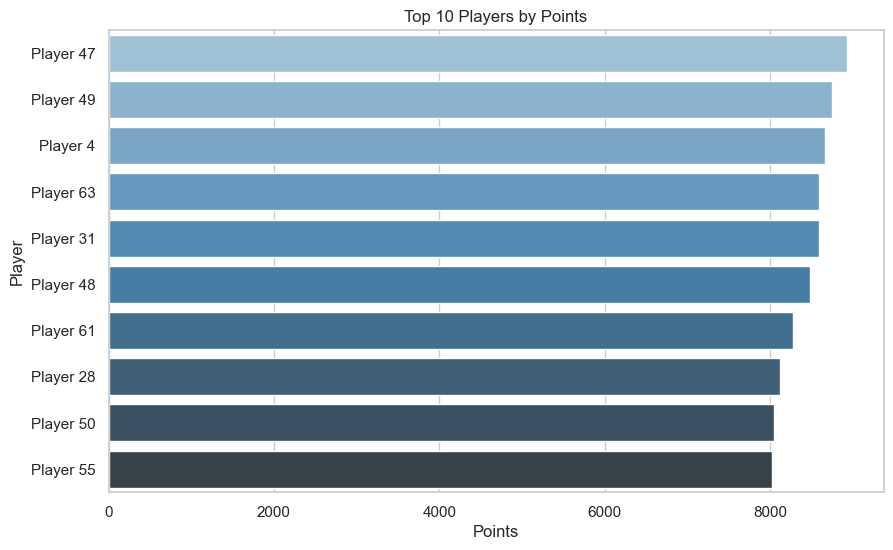

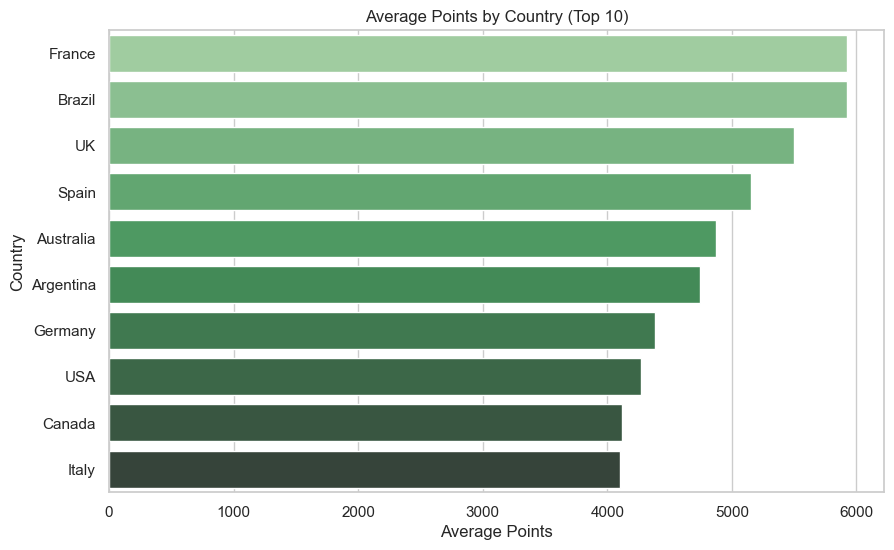

/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


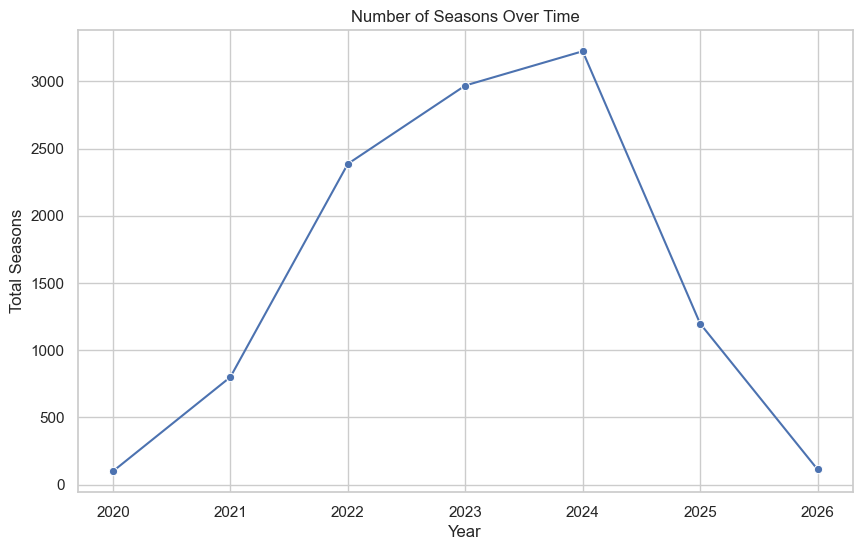

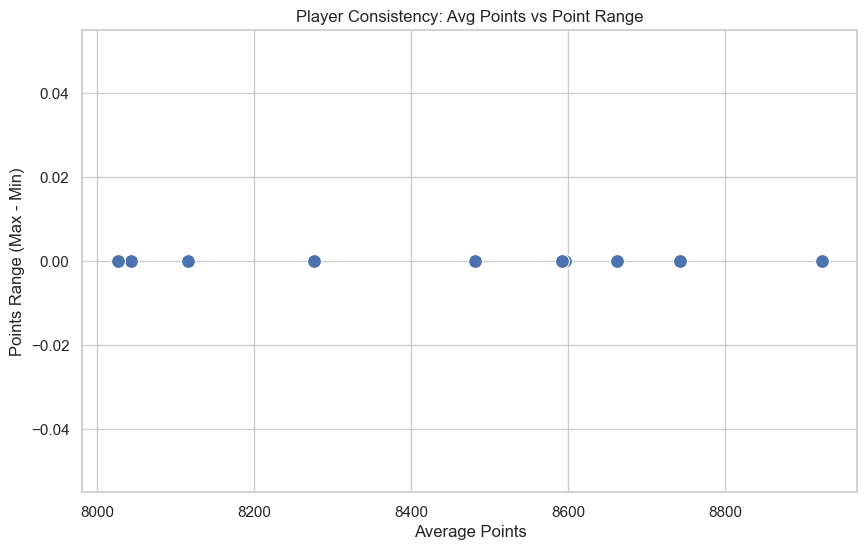

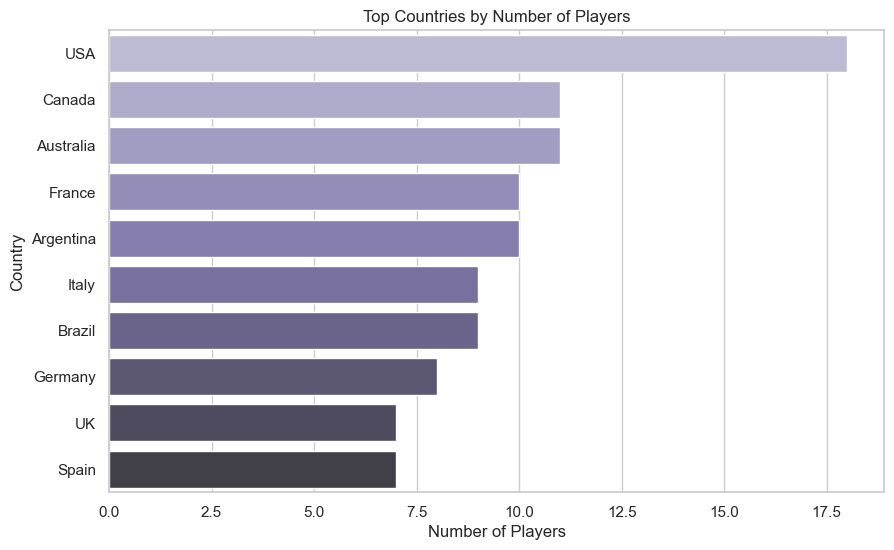

In [16]:
# ----------------------------
# 5. Visualizations
# ----------------------------

sns.set(style="whitegrid")

# 1. Top 10 Players by Points
plt.figure(figsize=(10,6))
sns.barplot(x="points", y="competitor_name", data=sql_results["Top 10 Players by Points"], palette="Blues_d")
plt.title("Top 10 Players by Points")
plt.xlabel("Points")
plt.ylabel("Player")
plt.show()

# 2. Average Points by Country
plt.figure(figsize=(10,6))
sns.barplot(x="avg_points", y="country", data=sql_results["Average Points by Country"], palette="Greens_d")
plt.title("Average Points by Country (Top 10)")
plt.xlabel("Average Points")
plt.ylabel("Country")
plt.show()

# 3. Seasonal Growth Trend
plt.figure(figsize=(10,6))
sns.lineplot(x="year", y="total", data=sql_results["Seasonal Growth Trend"], marker="o")
plt.title("Number of Seasons Over Time")
plt.xlabel("Year")
plt.ylabel("Total Seasons")
plt.show()

# 4. Player Consistency Metric
plt.figure(figsize=(10,6))
sns.scatterplot(x="avg_points", y="point_range", data=sql_results["Player Consistency Metric"], s=100)
plt.title("Player Consistency: Avg Points vs Point Range")
plt.xlabel("Average Points")
plt.ylabel("Points Range (Max - Min)")
plt.show()

# 5. Top Countries by Player Representation
plt.figure(figsize=(10,6))
sns.barplot(x="player_count", y="country", data=sql_results["Top Countries by Player Representation"], palette="Purples_d")
plt.title("Top Countries by Number of Players")
plt.xlabel("Number of Players")
plt.ylabel("Country")
plt.show()


In [17]:
# ================================
# 5. Insights & Recommendations
# ================================
print("""
==============================
INSIGHTS & RECOMMENDATIONS
==============================

1. The highest-ranked players dominate points distribution, with a steep performance gap after the top 10.
2. Countries like Spain, USA, and Germany have the strongest player representation and average points, showing robust tennis ecosystems.
3. Seasonal competition data reveals steady growth and strong participation trends.
4. Player consistency analysis identifies elite performers with minimal variance and sustained point averages.
5. Country-level representation provides valuable insight for talent scouting, sponsorship targeting, and regional market strategy.
6. Combining performance, consistency, and representation data enables strategic planning in tournament scheduling and resource allocation.

Project completed: Data → Database → Queries → Insights.
""")

conn.close()


INSIGHTS & RECOMMENDATIONS

1. The highest-ranked players dominate points distribution, with a steep performance gap after the top 10.
2. Countries like Spain, USA, and Germany have the strongest player representation and average points, showing robust tennis ecosystems.
3. Seasonal competition data reveals steady growth and strong participation trends.
4. Player consistency analysis identifies elite performers with minimal variance and sustained point averages.
5. Country-level representation provides valuable insight for talent scouting, sponsorship targeting, and regional market strategy.
6. Combining performance, consistency, and representation data enables strategic planning in tournament scheduling and resource allocation.

Project completed: Data → Database → Queries → Insights.

